# 03: Quadrature

In the past section we saw how natural and easy is to use a mesh to approximate the measure of a domain once we avail of bijective maps between the reference and the physical elements. 
In this section, on the pretext of exploring what are the other _low hanging fruits_ that meshes offer, we will introduce another cornerstone of Finite Elements Methods: _quadrature_.

Of course, our idea is to exploit the bijective maps for dragging the quadrature game on the reference element and then try to have the quadrature at the physical elements at a small price.

So let's start by adding to our toolbox a function for computing quadrature points and weights on a $d$-dimensional simplex:

In [1]:
import numpy as np

In [2]:
def simplexQuadrature( N, D ):

        def rquad( N, d ):
            #
            cof = 2 * np.array( range( N ) ) + d
            if d:
                A = ( d ** 2 ) / ( cof * ( cof + 2 ) )
            else:
                A = np.zeros( N )
            B = ( cof[1:] ** 2 - d ** 2 ) / ( 2 * cof[1:] * np.sqrt( cof[1:]**2 - 1 ) )
            M = np.diag( A ) + np.diag( B, -1 ) + np.diag( B, 1 )
            #
            x, V = np.linalg.eig( M )
            i = np.argsort( x )
            x = ( x[ i ] + 1 ) / 2
            w = V[ 0,i ]**2 / ( d + 1 )
            return x, w
        #
        X = np.ones( ( N ** D, D + 1 ) )
        W = np.ones( ( N ** D, ) )
        dim = np.ones( D, dtype = 'int32' )
        dim[0] = -1
        for d in range( 1, D + 1 ):
            # cornerstone of this implementation
            x, w = rquad( N, D - d )
            # some auxiliary arrays
            transposition = np.array( range( D ), dtype = 'int32' )
            transposition[ d - 1 ] = 0
            transposition[ 0 ] = d - 1
            tilation = np.ones( D, dtype = 'int32' ) * N
            tilation[ d - 1 ] = 1
            # create the structures you need
            x = np.transpose( x.reshape( dim ), transposition )
            w = np.transpose( w.reshape( dim ), transposition )
            # build X and W
            X[ :,d ] = X[ :,d-1 ] * np.tile( x, tilation ).reshape( -1, order = 'F' )
            W        = W          * np.tile( w, tilation ).reshape( -1, order = 'F' )

        # manipulate output
        X = - np.diff( X,1,1 )
        permutation = np.roll( np.array( range( D ), dtype = 'int32' ),1 )
        X = X[:,permutation]

        return X, W

Now, I want to stress that it is not in our interest to understand how the function ```simplexQuadrature``` works. I just stole it long time ago in some dark corner of the internet and it worked well ever since :)

The only thing you should clearly understand about quadrature is that there are points $x_1,x_2,\ldots,x_N \in \Omega$ and weights $w_1,w_2,\ldots,w_N \in \mathbb{R}$ for which
$$
\int_{\Omega} f(x) \mathrm{d}x \approx \sum_{q=1}^{N} f(x_q)w_q
$$
is a fine enough approximation.


Let's rather see it in action...

### Example 01: 1D quadrature

...by quadrating the sine function over the interval, idk, $\left[\pi, \frac{3}{2}\pi\right]$:
$$
\int_\pi^{\frac{3}{2}\pi} \sin(x) \mathrm{d}x = -1
$$

In [3]:
# this can be done in one big step
Points = np.linspace( np.pi, 3/2 * np.pi, 2 )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B ) # ofc this is dumb in 1D

X, W = simplexQuadrature( N = 3, D = 1 )
res = 0
for k in range(CList.shape[0]):
    for q in range(W.size):
        res = res + np.sin( B[k,:,:] @ X[q,:] + Points[CList[:,0]] ) * W[q] * dtB[:,None]
        # here you observe the JOINT actions of quadrature AND change of variables
print('# elements = 1, quadrature order = 3: Relative error is  %0.8e.' % np.abs( res + 1 ) )

# elements = 1, quadrature order = 3: Relative error is  8.12155550e-06.


In [4]:
# Or by using a larger quadrature order
Points = np.linspace( np.pi, 3/2 * np.pi, 2 )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

X, W = simplexQuadrature( N = 6, D = 1 )
res = 0
for k in range(CList.shape[0]):
    for q in range(W.size):
        res = res + np.sin( B[k,:,:] @ X[q,:] + Points[CList[:,0]] ) * W[q] * dtB[:,None]
print('# elements = 1, quadrature order = 6: Relative error is  %0.8e.' % np.abs( res + 1 ) )

# elements = 1, quadrature order = 6: Relative error is  4.66293670e-14.


In [5]:
# Or by refining a bit the mesh
Points = np.linspace( np.pi, 3/2 * np.pi, 10 )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

X, W = simplexQuadrature( N = 3, D = 1 )
res = 0
for k in range(CList.shape[0]):
    for q in range(W.size):
        res = res + np.sin( B[k,:,:] @ X[q,:] + Points[CList[k,0]] ) * W[q] * dtB[k,None]
print('# elements = 9, quadrature order = 3: Relative error is  %0.8e.' % np.abs( res + 1 ) )

# elements = 9, quadrature order = 3: Relative error is  1.40349954e-11.


**Make it faster**

However, we agreed that loops are very slow. 
This is especially nasty as we loop over the number of the elements (typically very numerous).
We now derive a technique for speeding things up.

First, notice that we can switch the order of the two loops:


In [6]:
res = 0
for q in range(W.size):
    for k in range(CList.shape[0]):
        res = res + np.sin( B[k,:,:] @ X[q,:] + Points[CList[k,0]] ) * W[q] * dtB[k,None]
print('# elements = 9, quadrature order = 3: Relative error is  %0.8e.' % np.abs( res + 1 ) )

# elements = 9, quadrature order = 3: Relative error is  1.40352174e-11.


Then, we collapse the inner loop as follows:

In [7]:
res = 0
for q in range(W.size):
    res = res + np.sin( B @ X[q,:] + Points[CList[:,0]] ) * W[q] * dtB[:,None]
res = np.sum( res )
print('# elements = 9, quadrature order = 3: Relative error is  %0.8e.' % np.abs( res + 1 ) )

# elements = 9, quadrature order = 3: Relative error is  1.40347733e-11.


In [87]:
import time 

Nv = 10**5
Points = np.linspace( np.pi, 3/2 * np.pi, Nv )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

X, W = simplexQuadrature( N = 3, D = 1 )

t = time.time()
res = 0
for k in range(CList.shape[0]):
    for q in range(W.size):
        res = res + np.sin( B[k,:,:] @ X[q,:] + Points[CList[k,0]] ) *  W[q] * dtB[k,None]
print('Unvectorised: %1.3f seconds.' % (time.time() - t))

t = time.time()
res = 0
for q in range(W.size):
    res = res + np.sin( B @ X[q,:] + Points[CList[:,0]] ) *  W[q] * dtB[:,None]
res = np.sum( res )
print('Vectorised: %1.3f seconds.' % (time.time() - t))

Unvectorised: 2.753 seconds.
Vectorised: 0.009 seconds.


In [90]:
# technically one could blow away even the last loop but it's not really worth it (could you say why?)
t = time.time()
Z =   np.sin( B @ X.T + Points[CList[:,0]][:,:,None] ).reshape((Nv-1,-1))
RES = dtB[:,None] * Z * W
print('Over-Vectorised: %1.3f seconds.' % (time.time() - t))

Over-Vectorised: 0.037 seconds.


It gets even better in higher dimension!! In fact, while in 1D ```Nv``` vertices induce ```Nv-1``` elements, in higher dimension elements are usually many more than vertices.
Also, the higher the dimension the more have to be quadrature points and weights to match the accuracy obtained in lower dimensions. I show you what I mean:

In [11]:
X, W = simplexQuadrature( N = 3, D = 1 )
print( X.shape )
print( W.shape )
print(' ')

X, W = simplexQuadrature( N = 3, D = 2 ) # same order, higher dimension
print( X.shape )
print( W.shape )
print(' ')

X, W = simplexQuadrature( N = 3, D = 3 ) # same order, higher dimension
print( X.shape )
print( W.shape )

(3, 1)
(3,)
 
(9, 2)
(9,)
 
(27, 3)
(27,)


Let's see another example in 2D then we will see a performance test on a 3D example.

### Example 02: compute L2 norm and integral of a function on a 2D crown section

Compute the $L_2$ norm and integral of the function
$$
f(\theta,\rho) = \sin(\theta)\cos(\theta)(\rho-r)(R-\rho), \quad \theta \in [0,\pi/2], \rho \in [r,R]
$$
over the crown section 2D domain with $r = 1$ and $R=2$.

In Cartesian coordinates this is
$$
f( x,y ) = 
\sin\left(\arccos\left(\frac{x}{\sqrt{x^2+y^2}}\right)\right)
\cos\left(\arccos\left(\frac{x}{\sqrt{x^2+y^2}}\right)\right)
%
\left(\sqrt{x^2+y^2}-r\right)\left(R-\sqrt{x^2+y^2}\right)
$$
with Jacobian
$$
\frac{1}{\sqrt{x^2+y^2}}.
$$

Analytically:
$$
\int_{\Omega} f(x) \mathrm{d}x = \frac{1}{12} \approx 0.083333333333333,
$$
and
$$
\sqrt{\int_{\Omega} f^2(x) \mathrm{d}x} = \sqrt{\frac{\pi}{480}} \approx 0.080901079689821.
$$

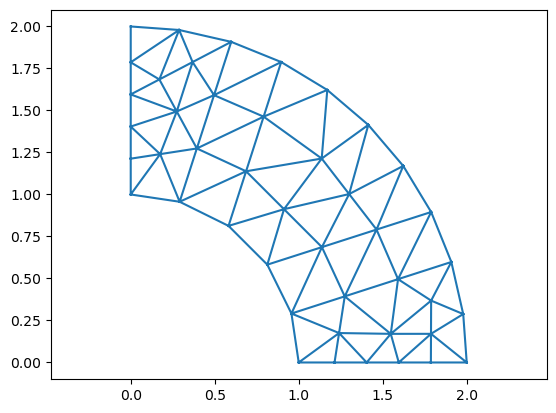

In [91]:
import meshio 
import matplotlib.pyplot as plt

mesh = meshio.read('../mesh-files/crown.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

<IPython.core.display.Javascript object>


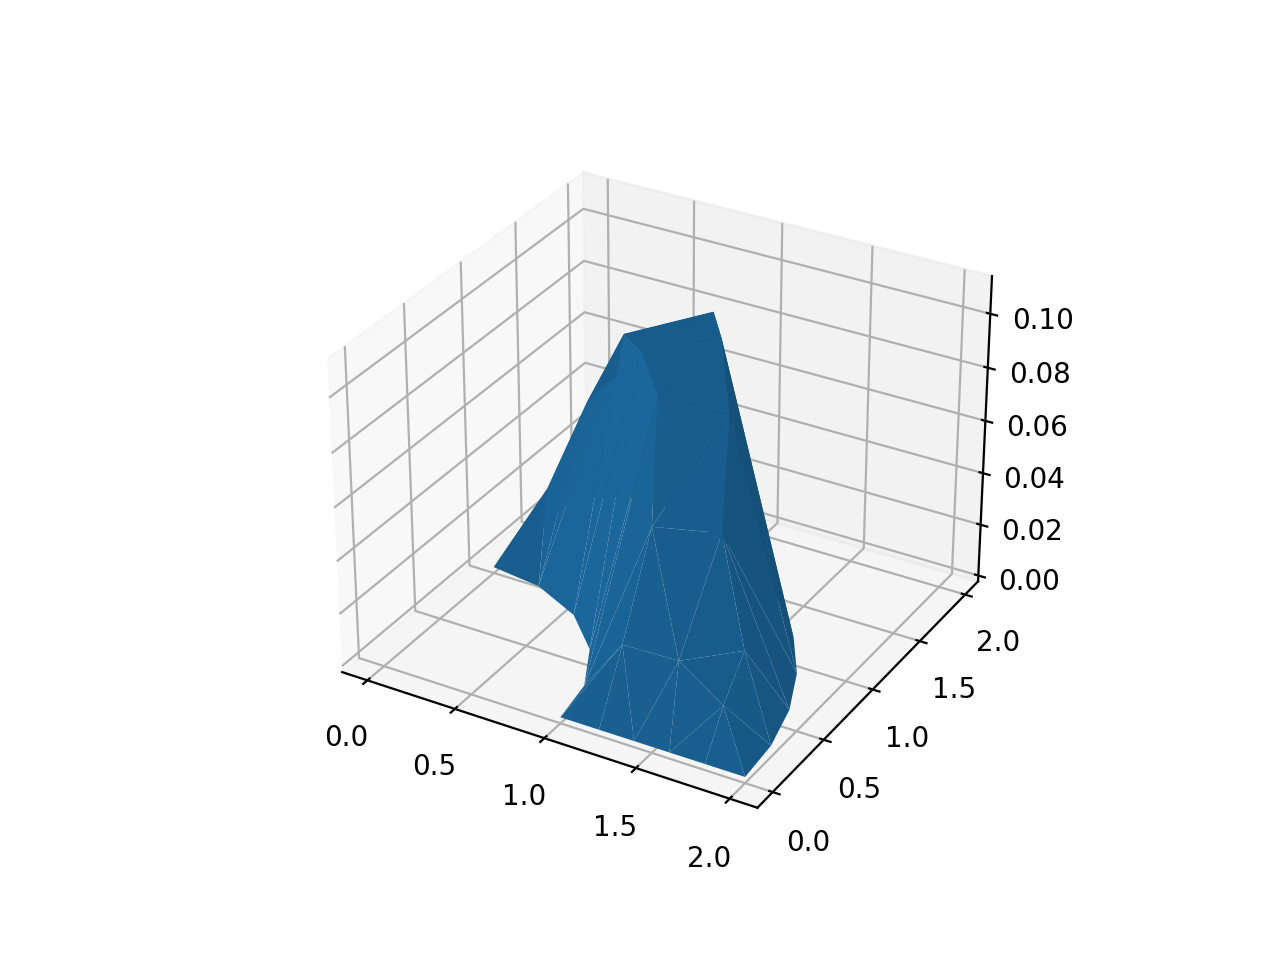

In [92]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Points = mesh.points[:,:2]  # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity

r = 1
R = 2

fig = plt.figure()
ax = fig.gca(projection='3d')
# for triangle in mesh.cells[0].data: # I can't see it anyway so
#     ax.triplot( Points[:,0], Points[:,1], triangles = CList )
z =    np.sin( np.arccos( Points[:,0] / np.sqrt( np.sum( Points**2,1 ) ) ) ) \
     * np.cos( np.arccos( Points[:,0] / np.sqrt( np.sum( Points**2,1 ) ) ) ) \
     * ( np.sqrt( np.sum( Points**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( Points**2,1 ) ) )
ax.plot_trisurf(Points[:,0], Points[:,1], z, triangles = CList )
plt.show()

In [93]:
# let's find int_Omega f dx
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

X, W = simplexQuadrature( N = 5, D = 2 )
res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z =   np.sin( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
        * np.cos( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
        * ( np.sqrt( np.sum( p**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( p**2,1 ) ) )
    jac = 1 / np.sqrt( np.sum( p**2,1 ) )
    res = res + z[:,None] * jac[:,None] * W[q] * dtB[:,None]
res = np.sum( res )
#print( res )
print('Integral of f. Relative error is  %0.8e.' % ( np.abs( res - 1/12 ) * 12 ) )
#

Integral of f. Relative error is  3.38272235e-04.


In [96]:
# technically one could blow away even the last loop but it's not really worth it (could you say why?)
P = ( B @ X.T + Points[CList[:,0]][:,:,None] )
Z =   np.sin( np.arccos( P[:,0,:] / np.sqrt( np.sum( P**2,1 ) ) ) ) \
    * np.cos( np.arccos( P[:,0,:] / np.sqrt( np.sum( P**2,1 ) ) ) ) \
    * ( np.sqrt( np.sum( P**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( P**2,1 ) ) )
JAC = 1 / np.sqrt( np.sum( P**2,1 ) )
RES = dtB[:,None] * (Z * JAC) * W
#print( RES.sum() )
print('Integral of f. Relative error is  %0.8e.' % ( np.abs( RES.sum() - 1/12 ) * 12 ) )

Integral of f. Relative error is  3.38272235e-04.


In [95]:
# let's find L2 norm of f
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

X, W = simplexQuadrature( N = 5, D = 2 )
res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z =   np.sin( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
        * np.cos( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
        * ( np.sqrt( np.sum( p**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( p**2,1 ) ) )
    jac = 1 / np.sqrt( np.sum( p**2,1 ) )
    res = res + z[:,None]**2 * jac[:,None] * W[q] * dtB[:,None]
res = np.sqrt( np.sum( res ) )
#print( res )
print('Integral of f. Relative error is  %0.8e.' % ( np.abs( res - np.sqrt(np.pi/480) ) * np.sqrt(480/np.pi) ) )

Integral of f. Relative error is  4.75726444e-06.


### Example 03: a performance test on 3D torus


Let's now consider the task of computing the volume of a portion $\Xi$ of the torus. For example the portion that in a cylindrical coordinates system $(\rho, \varphi, z)$ has $\varphi \in \left[0, \frac{\pi}{4} \right]$.
This amounts to integrating the indicator function $\mathbf{1}_{\Xi}(x)$.

Warning: this is not equivalent to what we did in the past section!! The region I want to measure could very well cut many tetrahedra in two disjoint pieces so I cannot compute this volume by adding up the measures of the tetrahedra belonging to my region!!

In [97]:
mesh = meshio.read('../mesh-files/torus_hard.vtu')

Points = mesh.points        # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity

Nv = Points.shape[0]
Nc = CList.shape[0]

print('In this mesh there are %u vertices and %u tetrahedra.' % (Nv, Nc) )

In this mesh there are 15331 vertices and 66700 tetrahedra.


In [98]:
def indicator( Points, phiA, phiB ):
    
    rho = np.sqrt( np.sum( Points[:,:2]**2,1 ) )
    phi = np.arcsin( Points[:,1] / rho )  
    id = np.argwhere( Points[:,0] < 0 )
    phi[ id ] = np.pi - phi[ id ]

    i_o = np.zeros( Points.shape[0] )    
    i_o[ np.argwhere( (phi > phiA) & (phi < phiB) ) ] = 1
    
    return i_o

In [99]:
d  = CList.shape[1] - 1 # why didn't I simply ask for Points.shape[1]?

B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

R = 0.6
r = 0.2

X, W = simplexQuadrature( N = 3, D = 3 )

phiA = 0
phiB = np.pi / 4


t = time.time()
res = 0
for k in range(CList.shape[0]):
    for q in range(W.size):
        res = res + indicator( (B[k,:,:] @ X[q,:] + Points[CList[k,0]])[None,:], phiA, phiB )[:,None] * W[q] * dtB[k,None]
print('Unvectorised: %1.3f seconds.' % (time.time() - t))

t = time.time()
res = 0
for q in range(W.size):
    res = res + indicator( B @ X[q,:] + Points[CList[:,0]], phiA, phiB )[:,None] * W[q] * dtB[:,None]
res = np.sum( res )
print('Vectorised: %1.3f seconds.' % (time.time() - t))

#Unvectorised: 109.781 seconds.
#  Vectorised: 0.254 seconds.

Unvectorised: 91.585 seconds.
Vectorised: 0.249 seconds.


In [100]:
print('Volume computed using quadrature %0.8e.' % ( res ) )
print('Volume computed  analytically    %0.8e.' % ( 2 * np.pi ** 2 * r ** 2 * R / 8 ) )

Volume computed using quadrature 5.92051785e-02.
Volume computed  analytically    5.92176264e-02.
